In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.ticker import MultipleLocator

# Use your provided n_body function
def n_body(t, x, p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle
            # Calculate displacement vector between bodies i and j
            r_ij = []
            for d in range(dimensions):
                displacement = x[j*dimensions + d] - x[i*dimensions + d]
                r_ij.append(displacement)

            r_ij = np.array(r_ij)
            r = np.sqrt(np.sum(r_ij**2))

            # Calculate gravitational force magnitude
            force_mag = G * masses[i] * masses[j] / (r**3)

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]

    return dxdt

Semimajor axis for 1/3 resonance: 2.501 AU
Semimajor axis for 1/2 resonance: 3.277 AU
Semimajor axis for 3/7 resonance: 2.957 AU
Semimajor axis for 2/5 resonance: 2.824 AU
Semimajor axis for 2/3 resonance: 3.970 AU


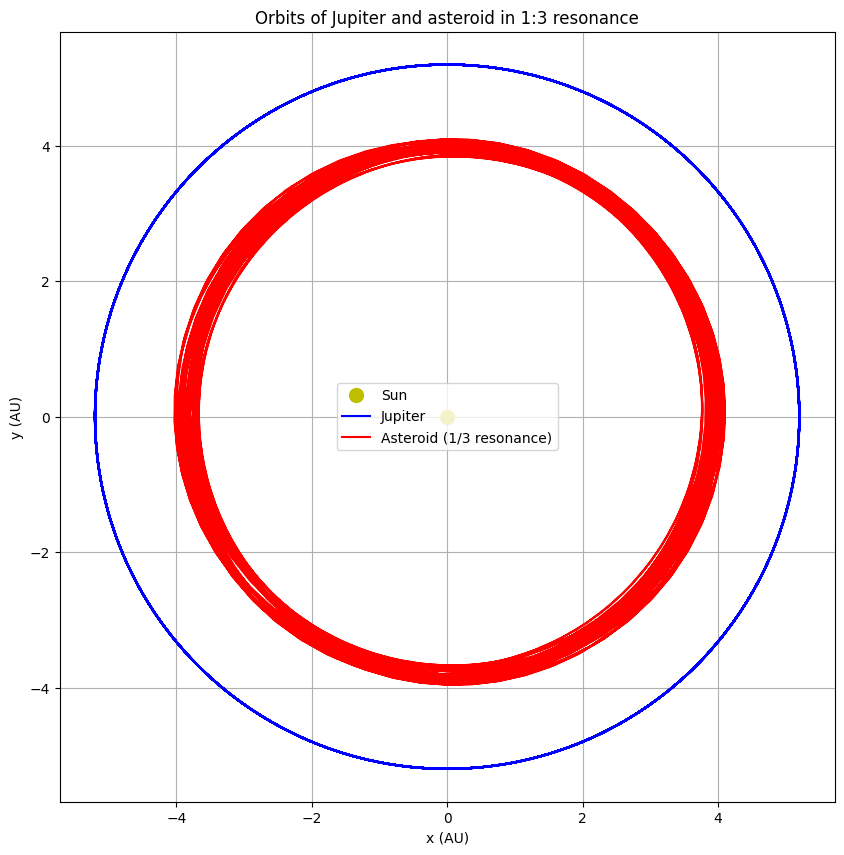

In [ ]:
# Set up physical parameters for our solar system
# We'll use the following model:
# - Sun: fixed at the origin
# - Jupiter: has mass = 0.001 * Sun's mass
# - Asteroid: very small mass (negligible)

# Define parameters
G = 4 * np.pi**2  # Gravitational constant in AU^3/yr^2/M_sun
M_sun = 1.0       # Mass of the Sun in solar masses
M_jupiter = 0.001 * M_sun  # Mass of Jupiter

# Set up the parameters dictionary
params = {
    'm': [M_sun, M_jupiter, 1e-10],  # Masses of Sun, Jupiter, asteroid
    'G': G,
    'dimension': 2,  # 2D simulation
    'fix_first': True  # Fix the Sun at the origin
}

# Jupiter's orbit
a_jupiter = 5.202  # Semimajor axis in AU
v_jupiter = np.sqrt(G * M_sun / a_jupiter)  # Circular velocity

# Function to run a simulation with a specific asteroid position
def simulate_asteroid(a_asteroid):
    """
    Run a simulation with an asteroid at the given semimajor axis

    Parameters:
    a_asteroid (float): Semimajor axis of the asteroid in AU

    Returns:
    tuple: (times, states)
    """
    # Calculate circular velocity for the asteroid
    v_asteroid = np.sqrt(G * M_sun / a_asteroid)

    # Initial state vector [x_sun, y_sun, x_jupiter, y_jupiter, x_asteroid, y_asteroid,
    #                       vx_sun, vy_sun, vx_jupiter, vy_jupiter, vx_asteroid, vy_asteroid]
    initial_state = np.array([
        0.0, 0.0,                    # Sun position (fixed)
        a_jupiter, 0.0,              # Jupiter position
        a_asteroid, 0.0,             # Asteroid position
        0.0, 0.0,                    # Sun velocity (fixed)
        0.0, v_jupiter,              # Jupiter velocity
        0.0, v_asteroid              # Asteroid velocity
    ])

    # Simulate for a sufficient time (e.g., 30 Jupiter years)
    t_span = [0, 30 * np.sqrt(a_jupiter**3)]

    # Solve ODE
    solution = solve_ivp(
        lambda t, y: n_body(t, y, params),
        t_span,
        initial_state,
        method='RK45',
        rtol=1e-8,
        atol=1e-8,
        dense_output=True
    )

    return solution.t, solution.y

# Let's try the 1/3 resonance
# The period ratio is 1/3, so the semimajor axis ratio is (1/3)^(2/3)
a_resonance_1_3 = a_jupiter * (1/3)**(2/3)
a_resonance_1_2 = a_jupiter * (1/2)**(2/3)
a_resonance_3_7 = a_jupiter * (3/7)**(2/3)
a_resonance_2_5 = a_jupiter * (2/5)**(2/3)
a_resonance_2_3 = a_jupiter * (2/3)**(2/3)
print(f"Semimajor axis for 1/3 resonance: {a_resonance_1_3:.3f} AU")
print(f"Semimajor axis for 1/2 resonance: {a_resonance_1_2:.3f} AU")
print(f"Semimajor axis for 3/7 resonance: {a_resonance_3_7:.3f} AU")
print(f"Semimajor axis for 2/5 resonance: {a_resonance_2_5:.3f} AU")
print(f"Semimajor axis for 2/3 resonance: {a_resonance_2_3:.3f} AU")

# Run simulation
t, states = simulate_asteroid(a_resonance_2_3)

# Plot the results
plt.figure(figsize=(10, 10))
plt.plot(0, 0, 'yo', markersize=10, label='Sun')
plt.plot(states[2], states[3], 'b-', label='Jupiter')
plt.plot(states[4], states[5], 'r-', label='Asteroid (1/3 resonance)')
plt.grid(True)
plt.axis('equal')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.title('Orbits of Jupiter and asteroid in 1:3 resonance')
plt.legend()
plt.show()

For 1:2 resonance (P = 1/2):
a = 5.202 × (1/2)^(2/3) = 5.202 × 0.6300 ≈ 3.277 AU
For 3:7 resonance (P = 3/7):
a = 5.202 × (3/7)^(2/3) = 5.202 × 0.5683 ≈ 2.956 AU
For 2:5 resonance (P = 2/5):
a = 5.202 × (2/5)^(2/3) = 5.202 × 0.5425 ≈ 2.822 AU
For 2:3 resonance (P = 2/3):
a = 5.202 × (2/3)^(2/3) = 5.202 × 0.7631 ≈ 3.970 AU